# (N)on-(E)uclidean (U)pgrading
---
#### Description of NEU:
The NEU meta-algorithm learns a geometry for the input and (input $\times$ output) spaces by deforming them with a universal class of homeomorphisms + robustifies the involved loss functions to improve generalizability of the new and very flexible model.  
$$
\begin{aligned}
f \mapsto& \, \rho \circ f \circ \phi\\
\mathbb{E}_{\mathbb{P}}[\ell(f(X))] \mapsto & \,\max_{\mathbb{Q}\sim \mathbb{P}}\, \mathbb{E}_{\mathbb{Q}}[\ell(\rho(\phi(X), f\circ \phi(X)))].
\end{aligned}
$$
$\rho=\pi\circ \tilde{\rho}$, and $\tilde{\rho}$ and $\phi$ are "universal homeomorphisms" on $\operatorname{dom}(f)$ and on $\operatorname{dom}(f)\times \operatorname{co-dom}(f)$, respectively.  

---

---

#### Description of regression problem: 
In this notebook we implement the regression problem
$$
\begin{aligned}
y_i =&  \,f(x_i)\delta_i + \epsilon_i, \qquad i=1,\dots,N\\
\epsilon_i \sim &\, \mathcal{N}(0,\sigma),\\
\delta_i\sim &  \,U(1-D,1+D),
\end{aligned}
$$
for some *variance* $\sigma>0$ and *degree of model misspecification level* $0<D<1$.  
The quantity $\epsilon$ can be understood as, classical, additive noise while the quantity $\delta$ represents multiplicative noise.

---

---

### Functions from the paper:
 - 1) $\min\{\exp(\frac{-1}{(1+x)^2}),x+\cos(x)\}$. Reason: Evaluate performance for pasted functions and general badness.
 - 2) $\cos(\exp(-x))$.  Reason: Evaluate performance for non-periodic osculations.
 - 3) $I_{(-\infty,\frac1{2})}$.  Reason: Evaluation performance on a single jump.  
 
 ---

## Initializations:

In [1]:
# Data Structuring
import numpy as np
import pandas as pd


# Pre-Processing
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from scipy.special import expit

# Regression
from sklearn.linear_model import LinearRegression
from scipy import linalg as scila

# Tensorflow
import tensorflow as tf
import keras as K
import keras.backend as Kb
from keras.layers import *
from keras.models import Model
from keras.models import Sequential
from keras import layers
from keras import utils as np_utils
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.constraints import NonNeg
from tensorflow.keras.optimizers import Adam

# Operating-System Related
import os
from pathlib import Path

# Visualization
from matplotlib.pyplot import figure

# z_Misc
import time
import math

Using TensorFlow backend.


## Check/Make Paths

In [2]:
Path('./outputs/models/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/Benchmarks/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/Benchmarks/Invertible_Networks/GLd_Net/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/Benchmarks/Invertible_Networks/Ed_Net/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/Benchmarks/Linear_Regression/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/NEU/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/NEU/Greedy_Initializations/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/NEU/Greedy_Initializations/Base_Regressor/').mkdir(parents=True, exist_ok=True)
Path('./outputs/tables/').mkdir(parents=True, exist_ok=True)
Path('./outputs/results/').mkdir(parents=True, exist_ok=True)
Path('./inputs/data/').mkdir(parents=True, exist_ok=True)

## Initialize Internal Variables/(Hyper)parameter(s)

In [3]:
#---------------------------------#
# General Formatting Parameter(s) #
#---------------------------------#
d = 1 # Dimension of X
D = 1 # Dimension of Y

#------------------------------------#
# Training/Optimization Parameter(s) #
#------------------------------------#
# Robustness Parameter
robustness_parameter = .1
# Training meta-parameters
Pre_Epochs = 50
Full_Epochs = 600

#---------------------------#
# Architecture Parameter(s) #
#---------------------------#
# 1) Base Model
#---------------#
Initial_Depth = 2
Initial_Height = 50
# 2) Feature Map
#---------------#
Feature_map_depth = 40
Feature_map_height = 5
# 3) Readout Map
#---------------#
# Reconfiguration Parameters
N_Reconfigurations = 50
# Depth & Height Per Reconfiguration
Depth_per_reconfig = 30
Height_per_reconfig = 5

#-------------------#
# Data Parameter(s) #
#-------------------#
# Test-set meta-parameters
Train_step_proportion = .5 # (i.e.: ratio of train to test-set sizes)
Extrapolation_size = .25 # (i.e.: size of test-train set domain (diameter/2))
# Train Data meta-parameters
N_data = 10**3 # (i.e.: N)
# Noise Parameters
noise_level = .5 # (i.e.: ε_i)
Distortion = .7 # (i.e.: δ_i)
# Unknown Function:
def unknown_f(x):
    return .1*x + .1*(x**4) + x*np.exp(-np.abs(x)) + np.sin(4*x + 3*x**2) + np.cos(7*(x**2))+ (x % .5)

### Run External/Auxiliary Notebooks

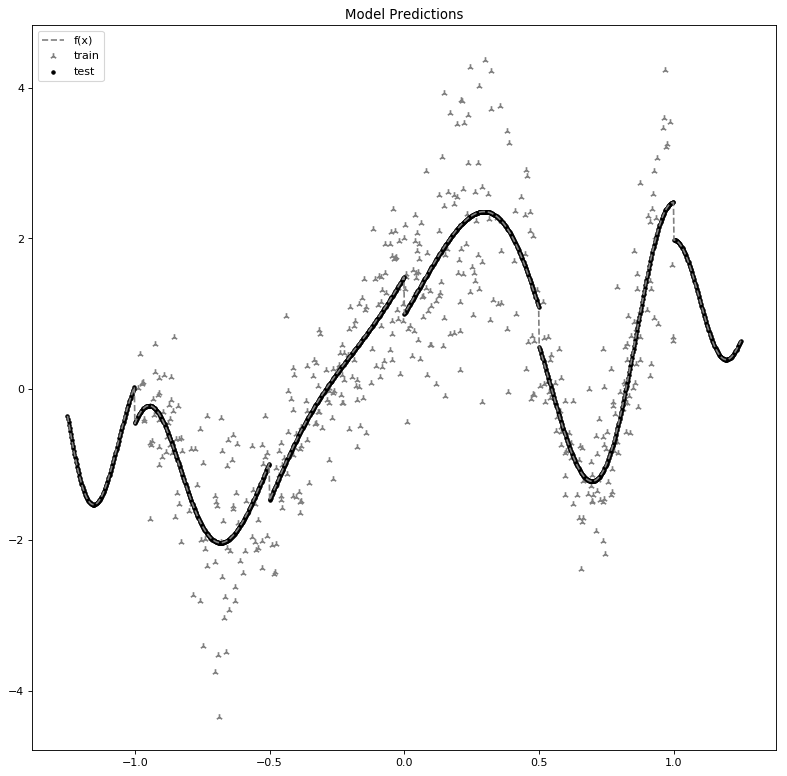

In [4]:
#------------------------#
# Run External Notebooks #
#------------------------#
# Generate Data
%run Data_Generator.ipynb
# Import Custom Layer(s)
%run Special_Layers_Homeomorphic.ipynb
# Import Utility for NEU
%run NEU_Util.ipynb
# Import Benchmarks
%run Benchmarks_Util.ipynb

#### Prepare data for NEU

## 1) Get Basic Regression Models
 1. Get Base regression model (benchmark),
 2. Get Base regression model for NEU.

## Get basic regression model - Benchmark

In [5]:
if os.path.exists('./outputs/models/Benchmarks/Linear_Regression/saved_model.pb'):
    #------------------#
    # Load Readout Map #
    #------------------#
    print('Benchmark model - already exists: Loading...')
    regression_Benchmark = tf.keras.models.load_model("./outputs/models/Benchmarks/Linear_Regression/")
    print('Benchmark model - already exists: Loaded.')
else:
    print('Pre-trained benchmark model does not exist: Training.')
    regression_Benchmark = def_model_Regression(data_x,
                                                data_y,
                                                Pre_Epochs_in=Full_Epochs,
                                                height=(N_Reconfigurations*Height_per_reconfig),
                                                depth=Initial_Depth,
                                                learning_rate=0.01)
    
    #-----------------#
    # Save Full-Model #
    #-----------------#
    print('Benchmark-Model: Saving')
    regression_Benchmark.save("./outputs/models/Benchmarks/Linear_Regression/")
    print('Benchmark-Model: Saved')
    
# Generate Predictions #
#----------------------#
predictions_OLS_Benchmark =  regression_Benchmark.predict(data_x)
predictions_OLS_Benchmark = predictions_OLS_Benchmark.reshape(-1,)
predictions_OLS_Benchmark_test =  regression_Benchmark.predict(data_x_test)
predictions_OLS_Benchmark_test = predictions_OLS_Benchmark_test.reshape(-1,)

Benchmark model - already exists: Loading...
Benchmark model - already exists: Loaded.


## 1+2) Get base regression model for NEU + Learn optimal feature map

In [6]:
if False:#os.path.exists('./outputs/models/Benchmarks/Greedy_Initializations/Base_Regressor/saved_model.pb'):
    #------------------#
    # Load Readout Map #
    #------------------#
    print('Base Regressor model - already exists: Loading...')
    regression_basic = tf.keras.models.load_model('./outputs/models/Benchmarks/Greedy_Initializations/Base_Regressor/', custom_objects={'Robust_MSE': Robust_MSE})
    print('Base Regressor model - already exists: Loaded.')
else:
    print('Pre-trained benchmark model does not exist: Training.')
    regression_basic = get_base_model_Regression(data_x, 
                                             data_NEU, 
                                             Pre_Epochs_in=Full_Epochs, 
                                             height=Initial_Height, 
                                             depth=Initial_Depth,
                                             feature_map_depth=Feature_map_depth,
                                             feature_map_height=Feature_map_height,
                                             learning_rate=0.01)
    
    
    #-----------------#
    # Save Full-Model #
    #-----------------#
    print('Base Regressor-Model: Saving')
    regression_basic.save("./outputs/models/Benchmarks/Greedy_Initializations/Base_Regressor/")
    print('Base Regressor-Model: Saved')
    
# Generate Predictions #
#----------------------#
predictions_OLS = regression_basic.predict(data_x)
predictions_OLS = predictions_OLS.reshape(-1,)
predictions_OLS_test = regression_basic.predict(data_x_test)

Pre-trained benchmark model does not exist: Training.
Epoch 1/600
16/16 - 0s - loss: 67.1017 - mse: 1.0733 - mae: 0.5848 - mape: 84.5330
Epoch 2/600
16/16 - 0s - loss: 66.6592 - mse: 0.8795 - mae: 0.5276 - mape: 141.3989
Epoch 3/600
16/16 - 0s - loss: 66.5555 - mse: 0.8394 - mae: 0.5146 - mape: 130.4453
Epoch 4/600
16/16 - 0s - loss: 66.4235 - mse: 0.7762 - mae: 0.4925 - mape: 148.1934
Epoch 5/600
16/16 - 0s - loss: 66.3050 - mse: 0.7548 - mae: 0.4772 - mape: 103.6306
Epoch 6/600
16/16 - 0s - loss: 66.0616 - mse: 0.6588 - mae: 0.4442 - mape: 94.9193
Epoch 7/600
16/16 - 0s - loss: 65.9716 - mse: 0.6234 - mae: 0.4328 - mape: 99.4156
Epoch 8/600
16/16 - 0s - loss: 65.9092 - mse: 0.6054 - mae: 0.4237 - mape: 94.1786
Epoch 9/600
16/16 - 0s - loss: 65.9403 - mse: 0.5960 - mae: 0.4272 - mape: 106.0061
Epoch 10/600
16/16 - 0s - loss: 65.9789 - mse: 0.6221 - mae: 0.4314 - mape: 93.4267
Epoch 11/600
16/16 - 0s - loss: 65.8886 - mse: 0.5949 - mae: 0.4184 - mape: 103.1414
Epoch 12/600
16/16 - 0s -

Epoch 97/600
16/16 - 0s - loss: 65.1462 - mse: 0.3349 - mae: 0.3179 - mape: 113.1963
Epoch 98/600
16/16 - 0s - loss: 65.1366 - mse: 0.3350 - mae: 0.3165 - mape: 122.4863
Epoch 99/600
16/16 - 0s - loss: 65.1483 - mse: 0.3364 - mae: 0.3172 - mape: 111.9627
Epoch 100/600
16/16 - 0s - loss: 65.1602 - mse: 0.3297 - mae: 0.3179 - mape: 116.2757
Epoch 101/600
16/16 - 0s - loss: 65.1477 - mse: 0.3327 - mae: 0.3165 - mape: 120.0190
Epoch 102/600
16/16 - 0s - loss: 65.0799 - mse: 0.3322 - mae: 0.3070 - mape: 108.7170
Epoch 103/600
16/16 - 0s - loss: 65.2380 - mse: 0.3515 - mae: 0.3301 - mape: 121.8579
Epoch 104/600
16/16 - 0s - loss: 65.1871 - mse: 0.3459 - mae: 0.3224 - mape: 115.0066
Epoch 105/600
16/16 - 0s - loss: 65.1748 - mse: 0.3353 - mae: 0.3210 - mape: 115.7661
Epoch 106/600
16/16 - 0s - loss: 65.1640 - mse: 0.3298 - mae: 0.3206 - mape: 115.7377
Epoch 107/600
16/16 - 0s - loss: 65.0940 - mse: 0.3211 - mae: 0.3100 - mape: 113.2231
Epoch 108/600
16/16 - 0s - loss: 65.1235 - mse: 0.3159 - 

Epoch 193/600
16/16 - 0s - loss: 65.1388 - mse: 0.3401 - mae: 0.3153 - mape: 110.9032
Epoch 194/600
16/16 - 0s - loss: 65.1978 - mse: 0.3538 - mae: 0.3238 - mape: 111.9409
Epoch 195/600
16/16 - 0s - loss: 65.2598 - mse: 0.3712 - mae: 0.3335 - mape: 114.8821
Epoch 196/600
16/16 - 0s - loss: 65.3222 - mse: 0.3859 - mae: 0.3410 - mape: 111.6080
Epoch 197/600
16/16 - 0s - loss: 65.2945 - mse: 0.3753 - mae: 0.3385 - mape: 117.0156
Epoch 198/600
16/16 - 0s - loss: 65.1452 - mse: 0.3294 - mae: 0.3173 - mape: 99.7773
Epoch 199/600
16/16 - 0s - loss: 65.0896 - mse: 0.3110 - mae: 0.3091 - mape: 114.0063
Epoch 200/600
16/16 - 0s - loss: 65.1675 - mse: 0.3351 - mae: 0.3187 - mape: 115.1763
Epoch 201/600
16/16 - 0s - loss: 65.0801 - mse: 0.3113 - mae: 0.3075 - mape: 110.7011
Epoch 202/600
16/16 - 0s - loss: 65.0986 - mse: 0.3265 - mae: 0.3091 - mape: 116.1384
Epoch 203/600
16/16 - 0s - loss: 65.1058 - mse: 0.3249 - mae: 0.3114 - mape: 99.7802
Epoch 204/600
16/16 - 0s - loss: 65.1117 - mse: 0.3251 -

Epoch 289/600
16/16 - 0s - loss: 65.1908 - mse: 0.3490 - mae: 0.3240 - mape: 101.3374
Epoch 290/600
16/16 - 0s - loss: 65.1279 - mse: 0.3185 - mae: 0.3150 - mape: 107.3205
Epoch 291/600
16/16 - 0s - loss: 65.1171 - mse: 0.3272 - mae: 0.3134 - mape: 113.6899
Epoch 292/600
16/16 - 0s - loss: 65.1012 - mse: 0.3298 - mae: 0.3110 - mape: 101.0243
Epoch 293/600
16/16 - 0s - loss: 65.1757 - mse: 0.3398 - mae: 0.3210 - mape: 124.1693
Epoch 294/600
16/16 - 0s - loss: 65.0840 - mse: 0.3142 - mae: 0.3089 - mape: 104.0053
Epoch 295/600
16/16 - 0s - loss: 65.1443 - mse: 0.3208 - mae: 0.3154 - mape: 107.6683
Epoch 296/600
16/16 - 0s - loss: 65.1259 - mse: 0.3198 - mae: 0.3140 - mape: 116.4045
Epoch 297/600
16/16 - 0s - loss: 65.0715 - mse: 0.3109 - mae: 0.3073 - mape: 110.7765
Epoch 298/600
16/16 - 0s - loss: 65.0880 - mse: 0.3172 - mae: 0.3090 - mape: 106.2419
Epoch 299/600
16/16 - 0s - loss: 65.0785 - mse: 0.3161 - mae: 0.3066 - mape: 111.0490
Epoch 300/600
16/16 - 0s - loss: 65.1224 - mse: 0.3266

Epoch 385/600
16/16 - 0s - loss: 65.0984 - mse: 0.3128 - mae: 0.3085 - mape: 107.4731
Epoch 386/600
16/16 - 0s - loss: 65.0957 - mse: 0.3161 - mae: 0.3084 - mape: 105.1244
Epoch 387/600
16/16 - 0s - loss: 65.1667 - mse: 0.3418 - mae: 0.3200 - mape: 109.7931
Epoch 388/600
16/16 - 0s - loss: 65.0778 - mse: 0.3139 - mae: 0.3076 - mape: 108.5018
Epoch 389/600
16/16 - 0s - loss: 65.0783 - mse: 0.3103 - mae: 0.3057 - mape: 105.6364
Epoch 390/600
16/16 - 0s - loss: 65.1116 - mse: 0.3237 - mae: 0.3121 - mape: 108.8773
Epoch 391/600
16/16 - 0s - loss: 65.1332 - mse: 0.3286 - mae: 0.3148 - mape: 113.0956
Epoch 392/600
16/16 - 0s - loss: 65.0549 - mse: 0.3143 - mae: 0.3043 - mape: 103.1518
Epoch 393/600
16/16 - 0s - loss: 65.0911 - mse: 0.3161 - mae: 0.3075 - mape: 109.0749
Epoch 394/600
16/16 - 0s - loss: 65.1151 - mse: 0.3249 - mae: 0.3118 - mape: 114.9328
Epoch 395/600
16/16 - 0s - loss: 65.1601 - mse: 0.3344 - mae: 0.3179 - mape: 117.9852
Epoch 396/600
16/16 - 0s - loss: 65.0733 - mse: 0.3162

Epoch 481/600
16/16 - 0s - loss: 65.0978 - mse: 0.3180 - mae: 0.3101 - mape: 107.1527
Epoch 482/600
16/16 - 0s - loss: 65.0838 - mse: 0.3170 - mae: 0.3085 - mape: 103.3892
Epoch 483/600
16/16 - 0s - loss: 65.1329 - mse: 0.3240 - mae: 0.3153 - mape: 110.6061
Epoch 484/600
16/16 - 0s - loss: 65.1286 - mse: 0.3309 - mae: 0.3144 - mape: 110.5274
Epoch 485/600
16/16 - 0s - loss: 65.0917 - mse: 0.3173 - mae: 0.3096 - mape: 110.3275
Epoch 486/600
16/16 - 0s - loss: 65.0781 - mse: 0.3135 - mae: 0.3066 - mape: 118.0878
Epoch 487/600
16/16 - 0s - loss: 65.1770 - mse: 0.3425 - mae: 0.3193 - mape: 105.4053
Epoch 488/600
16/16 - 0s - loss: 65.0905 - mse: 0.3197 - mae: 0.3076 - mape: 109.1954
Epoch 489/600
16/16 - 0s - loss: 65.1356 - mse: 0.3326 - mae: 0.3145 - mape: 109.9760
Epoch 490/600
16/16 - 0s - loss: 65.2353 - mse: 0.3540 - mae: 0.3291 - mape: 120.2442
Epoch 491/600
16/16 - 0s - loss: 65.1547 - mse: 0.3425 - mae: 0.3187 - mape: 115.8798
Epoch 492/600
16/16 - 0s - loss: 65.1081 - mse: 0.3297

Epoch 577/600
16/16 - 0s - loss: 65.1058 - mse: 0.3223 - mae: 0.3105 - mape: 116.1443
Epoch 578/600
16/16 - 0s - loss: 65.1217 - mse: 0.3208 - mae: 0.3133 - mape: 112.0489
Epoch 579/600
16/16 - 0s - loss: 65.0612 - mse: 0.3067 - mae: 0.3036 - mape: 104.6984
Epoch 580/600
16/16 - 0s - loss: 65.1071 - mse: 0.3190 - mae: 0.3096 - mape: 107.8010
Epoch 581/600
16/16 - 0s - loss: 65.0700 - mse: 0.3140 - mae: 0.3064 - mape: 106.0967
Epoch 582/600
16/16 - 0s - loss: 65.0823 - mse: 0.3245 - mae: 0.3089 - mape: 114.6868
Epoch 583/600
16/16 - 0s - loss: 65.2385 - mse: 0.3602 - mae: 0.3300 - mape: 117.6019
Epoch 584/600
16/16 - 0s - loss: 65.1014 - mse: 0.3270 - mae: 0.3096 - mape: 105.5195
Epoch 585/600
16/16 - 0s - loss: 65.0932 - mse: 0.3184 - mae: 0.3114 - mape: 109.8628
Epoch 586/600
16/16 - 0s - loss: 65.0948 - mse: 0.3188 - mae: 0.3094 - mape: 108.5312
Epoch 587/600
16/16 - 0s - loss: 65.1017 - mse: 0.3183 - mae: 0.3116 - mape: 110.5637
Epoch 588/600
16/16 - 0s - loss: 65.0884 - mse: 0.3190

### Generate Plots - Visualization

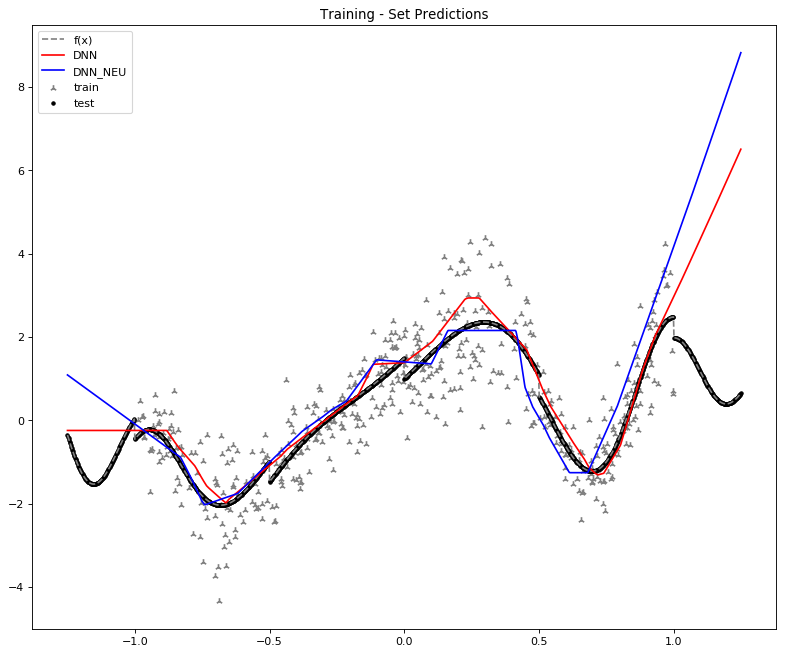

In [7]:
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

# Generate Plots #
#----------------#

# Plot Signal
plt.plot(np.array(data_x_test).reshape(-1,),data_y_test,color='gray',label='f(x)',linestyle='--')
# Plot Data
plt.scatter(np.array(data_x).reshape(-1,),data_y,color='gray',label='train', marker = '2')
plt.scatter(np.array(data_x_test).reshape(-1,),data_y_test,color='black',label='test', marker = '.')


# Plot Benchmark(s)
plt.plot(np.array(data_x_test).reshape(-1,),(predictions_OLS_Benchmark_test.reshape(-1,)), color = 'red', label='DNN')
# Plot NEU Regressors
plt.plot(np.array(data_x_test).reshape(-1,),predictions_OLS_test[:,1], color = 'blue',label='DNN_NEU')

# Format Plot #
#-------------#
plt.legend(loc="upper left")
plt.title("Training - Set Predictions")
plt.show()

## 3) Readout
 1. Get Base Model,
 2. Greedy Layer-Wise Initialization,
 3. Robust SGD on entire structure.
 
We train NEU-OLS, by unfreezing the greedily initialized layers, as per [this paper](https://papers.nips.cc/paper/3048-greedy-layer-wise-training-of-deep-networks.pdf), and using "robust"-SGD on the whole structure.

In [ ]:
#----------------------------------#
# Greedy Layer-Wise Initialization #
#----------------------------------#
if os.path.exists("./outputs/models/NEU/Greedy_Initializations/saved_model.pb"):
    #------------------#
    # Load Readout Map #
    #------------------#
    print('Pre-trained readout-map already exists: Loading.')
    NEU_OLS_Greedy_init = tf.keras.models.load_model("./outputs/models/NEU/Greedy_Initializations/")
    print('Saved pre-trained readout-map: Loaded.')
    #-----------------#
    # Load Full-Model #
    #-----------------#
    print('Full-model already exists: Loading.')
    NEU_OLS = tf.keras.models.load_model("./outputs/models/NEU/", custom_objects={'Robust_MSE': Robust_MSE})
    print('Full-Model: Loaded')
else:
    
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    #                                          Pre-Trained Model                                           #
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    
    print('Pre-trained model does not exist: Training.')
    # Greedy Initialization
    model = regression_basic
    NEU_OLS_Greedy_init = model
    for i in range(N_Reconfigurations):
        # Update Model
        NEU_OLS_Greedy_init_temp = add_reconfiguration_unit_greedily(NEU_OLS_Greedy_init,
                                                                     data_x,
                                                                     data_NEU,
                                                                     Pre_Epochs,
                                                                     Depth_per_reconfig,
                                                                     Height_per_reconfig)

        # Check for Blowup
        if math.isnan(np.mean(NEU_OLS_Greedy_init.predict(data_x))):
            NEU_OLS_Greedy_init = NEU_OLS_Greedy_init
            break
        else: #Update Model if not explosion
            NEU_OLS_Greedy_init = NEU_OLS_Greedy_init_temp

        #-------------#
        # Update User #
        #-------------#
        print(np.mean(np.abs((NEU_OLS_Greedy_init.predict(data_x) - data_NEU)**2)))
        # Update User on Status of Initialization
        print(((i+1)/N_Reconfigurations))
        
    # Update User of Pre-Training Completion
    print('Complete: Pre-Training Readout Map on Input x Output Space!')
    
    #------------------------------------#
    # Save Greedily Initialized Layer(s) #
    #------------------------------------#
    print('Saving Pre-Trained Readout on Input x Output Space!')
    NEU_OLS_Greedy_init.save("./outputs/models/NEU/Greedy_Initializations/")
    
    
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    #                                             Full Model                                               #
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    
    print('(Full-)Model does not exist: Training.')
    NEU_OLS = build_reconfiguration(model_greedy_initialized=NEU_OLS_Greedy_init, 
                                    trainx = data_x, 
                                    trainy = data_y, 
                                    Full_Epochs_in = Full_Epochs, 
                                    height = Height_per_reconfig)
    #-----------------#
    # Save Full-Model #
    #-----------------#
    print('Full-Model: Saving')
    NEU_OLS.save("./outputs/models/NEU/")
    print('Full-Model: Saved')
    

# Make Predictions #
#------------------#
# Predictions Train
NEU_OLS_greedy_initializations = NEU_OLS_Greedy_init.predict(data_x)
NEU_OLS_prediction = NEU_OLS.predict(data_x)
NEU_OLS_prediction = NEU_OLS_prediction.reshape(-1,)
# Predictions Test
NEU_OLS_greedy_initializations_test = NEU_OLS_Greedy_init.predict(data_x_test)
NEU_OLS_prediction_test = NEU_OLS.predict(data_x_test)
NEU_OLS_prediction_test = NEU_OLS_prediction_test.reshape(-1,)

    
# Update User #
#-------------#
print('NEU: Ready!')

Pre-trained model does not exist: Training.
1.9308687746979412
0.02
0.6384585843103187
0.04
4.534234248712429
0.06
1.1621298334797994
0.08
1.857060794856532
0.1


### Generate Plots - Visualization

In [ ]:
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')

# Generate Plots #
#----------------#

# Plot Signal
plt.plot(np.array(data_x_test).reshape(-1,),data_y_test,color='gray',label='f(x)',linestyle='--')
# Plot Data
plt.scatter(np.array(data_x).reshape(-1,),data_y,color='gray',label='train', marker = '2')
plt.scatter(np.array(data_x_test).reshape(-1,),data_y_test,color='black',label='test', marker = '.')

# Plot Benchmark(s)
plt.plot(np.array(data_x_test).reshape(-1,),(predictions_OLS_Benchmark_test), color = 'red', label='DNN')


# Plot NEU Regressors
plt.plot(np.array(data_x_test).reshape(-1,),predictions_OLS_test[:,1], color = 'blue',label='DNN_NEU')
plt.plot(np.array(data_x_test).reshape(-1,),(NEU_OLS_greedy_initializations_test[:,-1]), color = 'lightgreen',label='NEU-Reg-Init')
plt.plot(np.array(data_x_test).reshape(-1,),(NEU_OLS_prediction_test), color = 'green',label='NEU-Reg')

# Format Plot #
#-------------#
plt.legend(loc="upper left")
plt.title("Model Predictions")
plt.show()

---
---
---

# Benchmark Models

In [ ]:
#------------------#
# Train GLd-Model  #
#------------------#
if os.path.exists("./outputs/models/Benchmarks/Invertible_Networks/GLd_Net/saved_model.pb"):
    print('GLd-Nets Trained model already exists: Loading.')
    Deep_GLd = tf.keras.models.load_model("./outputs/models/Benchmarks/Invertible_Networks/GLd_Net/")
    print('GLd-Nets trained model: Loaded.')
else:
    print('GLd-Nets Model does not exist: Training.')
    # Basic Model
    regression_basic_nonrobust = get_base_model_Regression_nonrobust(data_x, 
                                             data_NEU, 
                                             Pre_Epochs_in=200, 
                                             height=100, 
                                             depth=10,
                                             learning_rate=0.01)
    # NEU Version
    Deep_GLd = build_reconfiguration_GLd(model_greedy_initialized=regression_basic_nonrobust, 
                                    trainx = data_x, 
                                    trainy = data_y, 
                                    Full_Epochs_in = Full_Epochs, 
                                    depth= (Depth_per_reconfig*N_Reconfigurations))
    
    #--------------------#
    # Save GLd-Net-Model #
    #--------------------#
    print('GLd-Nets Model: Saving')
    Deep_GLd.save("./outputs/models/Benchmarks/Invertible_Networks/GLd_Net/")
    print('GLd-Nets Model: Saved')

    
# Predictions Train
Deep_GLd_prediction = Deep_GLd.predict(data_x)
Deep_GLd_prediction = Deep_GLd_prediction.reshape(-1,)
# Predictions Test
Deep_GLd_prediction_test = Deep_GLd.predict(data_x_test)
Deep_GLd_prediction_test = Deep_GLd_prediction_test.reshape(-1,)
    
# Update User #
#-------------#
print('Benchmark Model - GLd-Nets: Ready!')

In [ ]:
#-----------------#
# Train Ed-Model  #
#-----------------#
if os.path.exists("./outputs/models/Benchmarks/Invertible_Networks/Ed_Net/saved_model.pb"):
    print('Ed-Nets Trained model already exists: Loading.')
    Deep_Ed = tf.keras.models.load_model("./outputs/models/Benchmarks/Invertible_Networks/Ed_Net/")
    print('Ed-Nets trained model: Loaded.')
else:
    print('Ed-Nets Model does not exist: Training.')
    Deep_Ed=build_reconfiguration_Ed(model_greedy_initialized=regression_basic_nonrobust, 
                                    trainx = data_x, 
                                    trainy = data_y, 
                                    Full_Epochs_in = Full_Epochs, 
                                    depth= (Depth_per_reconfig*N_Reconfigurations))
    
    #--------------------#
    # Save GLd-Net-Model #
    #--------------------#
    print('Ed-Nets Model: Saving')
    Deep_Ed.save("./outputs/models/Benchmarks/Invertible_Networks/Ed_Net/")
    print('Ed-Nets Model: Saved')
    
    
# Predictions Train
Deep_Ed_prediction = Deep_Ed.predict(data_x)
Deep_Ed_prediction = Deep_Ed_prediction.reshape(-1,)
# Predictions Test
Deep_Ed_prediction_test = Deep_Ed.predict(data_x_test)
Deep_Ed_prediction_test = Deep_Ed_prediction_test.reshape(-1)
    
# Update User #
#-------------#
print('Benchmark Model - Ed-Nets: Ready!')

Run univariate regression benchmarks file:

In [ ]:
# Run Univariate Regression File #
#--------------------------------#
%run Univariate_Regression_Benchmark_Models.ipynb

## Model Evaluation: 
*Record Error(s)/Prediction Quality*

Train results.

In [ ]:
# Train Set #
#-----------#
Vanilla = get_results(predictions_OLS_Benchmark,data_y)
NEU = get_results(NEU_OLS_prediction,data_y)
NEU_Gld = get_results(Deep_GLd_prediction,data_y)
NEU_Ed = get_results(Deep_Ed_prediction,data_y)
SSplines = get_results(f_hat_smoothing_splines_train,data_y)
LOESS = get_results(LOESS_prediction_train,data_y)

# Write to DataFrame
Results = pd.DataFrame({'Vanilla': Vanilla,
                             'NEU': NEU,
                             'NEU_GLd': NEU_Gld,
                             'NEU_Ed':NEU_Ed,
                             'Smoothing_Splines':SSplines,
                             'LOESS':LOESS},index={'MAE','MinE','MaxE','MSE','rMSE'})
# Format
Results = pd.DataFrame.transpose(Results)

# Write Results to file #
#-----------------------#
Results.to_latex('./outputs/results/Performance.txt')
# Write to Txt
cur_path = os.path.expanduser('./outputs/results/Performance_text.txt')
with open(cur_path, "w") as f:
    f.write(str(Results))

Test results.

In [ ]:
# Test Set #
#----------#
Vanilla = get_results(predictions_OLS_Benchmark_test,data_y_test)
NEU = get_results(NEU_OLS_prediction_test,data_y_test)
NEU_Gld = get_results(Deep_GLd_prediction_test,data_y_test)
NEU_Ed = get_results(Deep_Ed_prediction_test,data_y_test)
SSplines = get_results(f_hat_smoothing_splines_test,data_y_test)
LOESS = get_results(LOESS_prediction_test,data_y_test)

# Write to DataFrame
Results_test = pd.DataFrame({'Vanilla': Vanilla,
                             'NEU': NEU,
                             'NEU_GLd': NEU_Gld,
                             'NEU_Ed':NEU_Ed,
                             'Smoothing_Splines':SSplines,
                             'LOESS':LOESS},index={'MAE','MinE','MaxE','MSE','rMSE'})
# Format
Results_test = pd.DataFrame.transpose(Results_test)

# Write Results to file #
#-----------------------#
Results_test.to_latex('./outputs/results/Performance_test.txt')
# Write to Txt
cur_path = os.path.expanduser('./outputs/results/Performance_test_text.txt')
with open(cur_path, "w") as f:
    f.write(str(Results_test))

# Visualize Predictions

In [ ]:
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')

# Generate Plots #
#----------------#

# Plot Signal
plt.plot(np.array(data_x_test).reshape(-1,),data_y_test,color='gray',label='f(x)',linestyle='--')
# Plot Data
plt.scatter(np.array(data_x).reshape(-1,),data_y,color='gray',label='train', marker = '2')
plt.scatter(np.array(data_x_test).reshape(-1,),data_y_test,color='black',label='test', marker = '.')

# Plot Benchmark(s)
#------------------#
# Standard Benchmarks
plt.plot(np.array(data_x_test).reshape(-1,),(predictions_OLS_Benchmark_test), color = 'red', label='DNN')
# Plot Univariate Benchmark(s)
plt.plot(np.array(data_x_test).reshape(-1,),f_hat_smoothing_splines_test,color='pink',label='Splines')
plt.plot(np.array(data_x_test).reshape(-1,),LOESS_prediction_test,color='purple',label='LOESS')
# NEU Benchmarks: Alternatives to reconfigurations
plt.plot(np.array(data_x_test).reshape(-1,),Deep_GLd_prediction_test,color='lightblue',label='Deep-GLd')
plt.plot(np.array(data_x_test).reshape(-1,),Deep_Ed_prediction_test,color='orange',label='Deep-Ed')

# Plot NEU Regressors
# ---------------------------------- for INDEV  only: BEGIN --------------------------------------------------- #
# plt.plot(np.array(data_x_test).reshape(-1,),predictions_OLS_test[:,1], color = 'blue',label='DNN_NEU')
# plt.plot(np.array(data_x_test).reshape(-1,),(NEU_OLS_greedy_initializations_test[:,-1]), color = 'lightgreen',label='NEU-Reg-Init')
# ---------------------------------- for INDEV  only: END ----------------------------------------------------- #
plt.plot(np.array(data_x_test).reshape(-1,),(NEU_OLS_prediction_test), color = 'green',label='NEU-Reg')

# Format Plot #
#-------------#
plt.legend(loc="upper left")
plt.title("Model Predictions")
plt.show()

 ---

# Report Results

In [ ]:
print('Train Results:')
Results.style.apply(lambda col: ['font-weight:bold' if x==col.min() else '' for x in col])

In [ ]:
print('Test Results:')
Results_test.style.apply(lambda col: ['font-weight:bold' if x==col.min() else '' for x in col])

#### The END

---